# Test fast.ai SageMaker Endpoint
_**Testing a fastai based Pre-Trained Model with Amazon SageMaker Endpoint**_

## Randomly select test image
Randomly select an image from the test folder to submit to the SageMaker prediction endpoint.

In [1]:
import os
import random
import time
import json

import boto3

In [30]:
#dir_name = 'data/dogscats/train/dogs/'
dir_name = 'data/dogscats/test1/'
endpoint_name = 'lhr-summit-endpoint'

data/dogscats/test1/11815.jpg


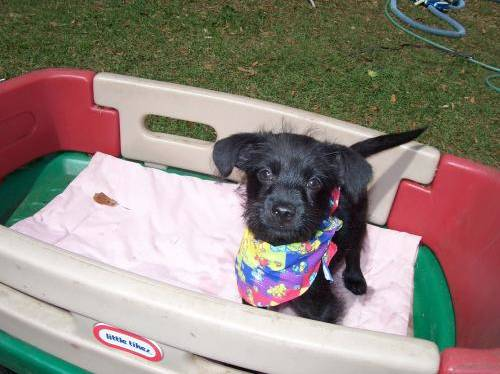

In [60]:
file_name = dir_name + random.choice(os.listdir(dir_name)) #change dir name to whatever
print(file_name)
#file_name = 'data/dogscats/test1/9969.jpg'
# test image
from IPython.display import Image
Image(file_name)

In [61]:
!md5sum {file_name}

b3a38564faab87032023a28d135fcf3b  data/dogscats/test1/11815.jpg


## Call Endpoint
Call the endpoint with some test data.

In [73]:
%%time

runtime = boto3.Session().client('runtime.sagemaker')
print(f"Filename is {file_name}")
with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)
response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/x-image', 
                                   Body=payload)
result = response['Body'].read()
print(json.loads(result))

Filename is data/dogscats/test1/11815.jpg
{'result': {'class': 'dogs', 'confidence': 0.8407800197601318}}
CPU times: user 28 ms, sys: 4 ms, total: 32 ms
Wall time: 233 ms
